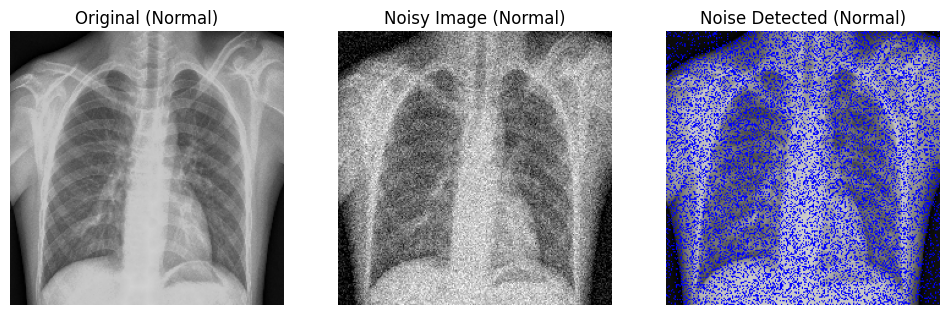

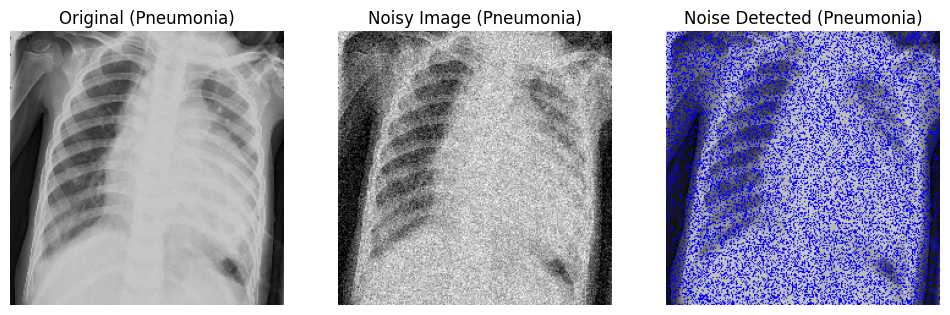

In [15]:
def detect_noisy_parts(original_img, noisy_img, threshold=25):
    """
    Detect noisy parts by computing the absolute difference between the original
    and noisy image and applying a threshold.

    Args:
        original_img: Original clean image (H, W, C).
        noisy_img: Noisy version of the same image (H, W, C).
        threshold: Intensity difference threshold to classify as noise.

    Returns:
        noise_mask: Binary mask highlighting the noisy parts.
        noise_overlay: Image with noisy parts highlighted in red.
    """
    # Compute absolute difference between original and noisy images
    diff = cv2.absdiff(original_img, noisy_img)
    diff_gray = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)

    # Threshold to detect noise
    _, noise_mask = cv2.threshold(diff_gray, threshold, 255, cv2.THRESH_BINARY)

    # Highlight noisy regions on the original image
    noise_overlay = original_img.copy()
    noise_overlay[noise_mask > 0] = [255, 0, 0]  # Highlight in red

    return noise_mask, noise_overlay

# Detect noisy parts in normal lung image
normal_noise_mask, normal_noise_overlay = detect_noisy_parts(normal_sample, noisy_normal)

# Detect noisy parts in pneumonia lung image
pneumonia_noise_mask, pneumonia_noise_overlay = detect_noisy_parts(pneumonia_sample, noisy_pneumonia)

# Visualize noisy regions for normal lung
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].set_title("Original (Normal)")
axes[0].imshow(cv2.cvtColor(normal_sample, cv2.COLOR_BGR2RGB))
axes[0].axis('off')

axes[1].set_title("Noisy Image (Normal)")
axes[1].imshow(cv2.cvtColor(noisy_normal, cv2.COLOR_BGR2RGB))
axes[1].axis('off')

axes[2].set_title("Noise Detected (Normal)")
axes[2].imshow(cv2.cvtColor(normal_noise_overlay, cv2.COLOR_BGR2RGB))
axes[2].axis('off')

plt.show()

# Visualize noisy regions for pneumonia lung
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].set_title("Original (Pneumonia)")
axes[0].imshow(cv2.cvtColor(pneumonia_sample, cv2.COLOR_BGR2RGB))
axes[0].axis('off')

axes[1].set_title("Noisy Image (Pneumonia)")
axes[1].imshow(cv2.cvtColor(noisy_pneumonia, cv2.COLOR_BGR2RGB))
axes[1].axis('off')

axes[2].set_title("Noise Detected (Pneumonia)")
axes[2].imshow(cv2.cvtColor(pneumonia_noise_overlay, cv2.COLOR_BGR2RGB))
axes[2].axis('off')

plt.show()


Noise removed



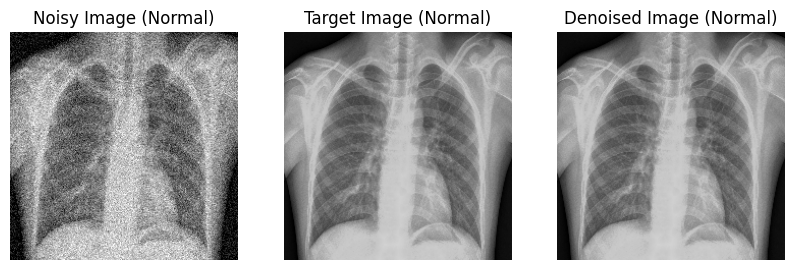

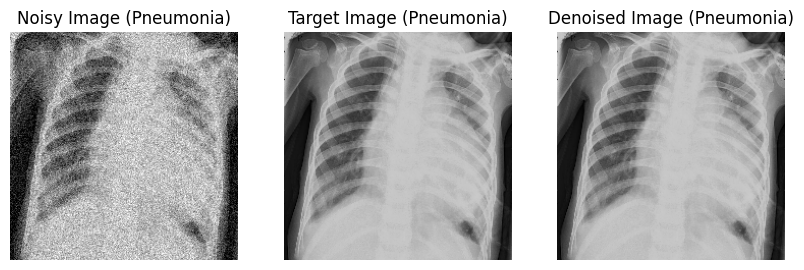

In [14]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import cv2

def load_images(folder, category):
    img_files = glob.glob(os.path.join(folder, category, '*.jpeg'))
    images = []
    for img_path in img_files:
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        if img is not None:
            images.append(img)
    return np.array(images, dtype=object) if images else np.empty((0,), dtype=object)

def preprocess_images(images, dimension):
    return np.array([cv2.resize(img, (dimension, dimension)) for img in images if img is not None])

def add_gaussian_noise(images, mean=0, stddev=25):
    noisy_images = []
    for img in images:
        noise = np.random.normal(mean, stddev, img.shape[:2])  # Add noise to grayscale shape
        noisy_img = img.astype(np.float32)
        noisy_img[:, :, 0] += noise
        noisy_img[:, :, 1] += noise
        noisy_img[:, :, 2] += noise
        noisy_img = np.clip(noisy_img, 0, 255).astype(np.uint8)
        noisy_images.append(noisy_img)
    return np.array(noisy_images)

def remove_text(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, binary_mask = cv2.threshold(gray_image, 200, 255, cv2.THRESH_BINARY_INV)
    text_mask = cv2.bitwise_not(binary_mask)
    inpainted_image = cv2.inpaint(image, text_mask, inpaintRadius=3, flags=cv2.INPAINT_TELEA)
    return inpainted_image

# Set the base path for your dataset
base_path = "/content/drive/MyDrive/chest_xray/chest_xray"
train_path = os.path.join(base_path, 'train')
val_path = os.path.join(base_path, 'val')
test_path = os.path.join(base_path, 'test')

# Load images
normal_images = load_images(test_path, category='NORMAL')
pneumonia_images = load_images(test_path, category='PNEUMONIA')

dimension = 224  # Set image dimension

# Preprocess and clean images
normal_images = preprocess_images([remove_text(img) for img in normal_images], dimension)
pneumonia_images = preprocess_images([remove_text(img) for img in pneumonia_images], dimension)

# Pick one normal and one pneumonia image
normal_sample = normal_images[0]
pneumonia_sample = pneumonia_images[0]

# Add noise to the selected images
noisy_normal = add_gaussian_noise([normal_sample])[0]
noisy_pneumonia = add_gaussian_noise([pneumonia_sample])[0]

# Placeholder denoised images (same as original for now)
denormalized_normal = normal_sample
denormalized_pneumonia = pneumonia_sample

def visualize_single_pair(noisy_img, original_img, denoised_img, label):
    fig, axes = plt.subplots(1, 3)
    fig.set_size_inches(10, 3)

    axes[0].set_title(f'Noisy Image ({label})')
    axes[0].imshow(cv2.cvtColor(noisy_img, cv2.COLOR_BGR2RGB))
    axes[0].axis('off')

    axes[1].set_title(f'Target Image ({label})')
    axes[1].imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
    axes[1].axis('off')

    axes[2].set_title(f'Denoised Image ({label})')
    axes[2].imshow(cv2.cvtColor(denoised_img, cv2.COLOR_BGR2RGB))
    axes[2].axis('off')

    plt.show()

# Visualize normal lung
visualize_single_pair(noisy_normal, normal_sample, denormalized_normal, "Normal")

# Visualize pneumonia lung
visualize_single_pair(noisy_pneumonia, pneumonia_sample, denormalized_pneumonia, "Pneumonia")


Importing libs and loading data content.

In [2]:
from google.colab import drive
import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Mount Google Drive to access files
drive.mount('/content/drive')

# Path to your data
normal_path = "/content/drive/MyDrive/chest_xray/chest_xray/train/NORMAL/IM-0526-0001.jpeg"
pneumonia_path = "/content/drive/MyDrive/chest_xray/chest_xray/train/PNEUMONIA/person53_bacteria_252.jpeg"


Mounted at /content/drive


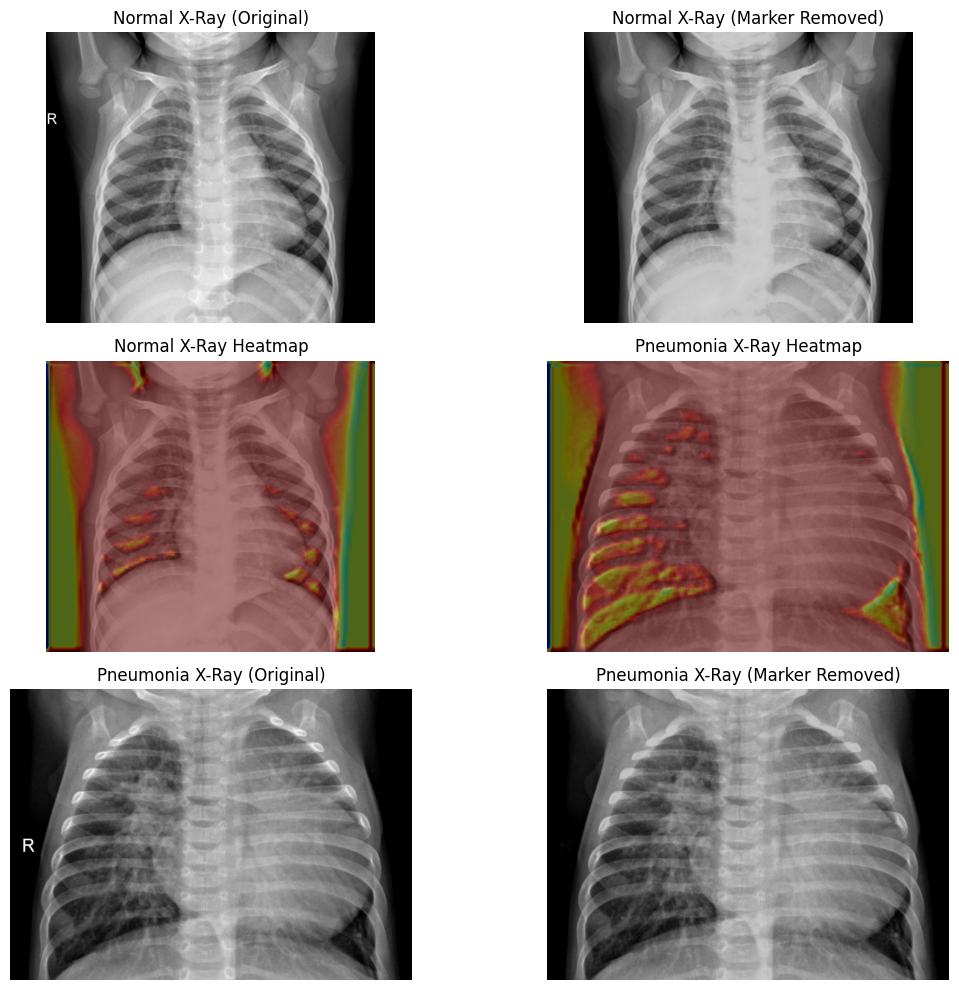

In [11]:

# Define the SimpleXRayModel
class SimpleXRayModel:
    def __init__(self):
        # Model architecture (simple CNN)
        self.model = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.Linear(32 * 56 * 56, 2),
            nn.Softmax(dim=1)
        )
        self.model.eval()

        # Preprocessing pipeline
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5])
        ])

        # Grad-CAM related attributes
        self.gradients = None
        self.features = None
        self.target_layer = self.model[4]  # Conv2d layer after second maxpool

        # Hooks to capture gradients and features
        def grad_hook_fn(module, grad_input, grad_output):
            self.gradients = grad_output[0].detach()

        def feature_hook_fn(module, input, output):
            self.features = output.detach()

        self.grad_hook = self.target_layer.register_backward_hook(grad_hook_fn)
        self.feature_hook = self.target_layer.register_forward_hook(feature_hook_fn)

    def remove_text(self, image):
        # Function to remove text markers (L and R) from X-ray images
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        _, binary_mask = cv2.threshold(gray_image, 200, 255, cv2.THRESH_BINARY_INV)
        text_mask = cv2.bitwise_not(binary_mask)
        inpainted_image = cv2.inpaint(image, text_mask, inpaintRadius=3, flags=cv2.INPAINT_TELEA)
        return inpainted_image

    def process_image(self, image_path):
        # Function to load and process image (remove markers, apply transform)
        try:
            img = cv2.imread(image_path)  # Read image with OpenCV
            img_no_markers = self.remove_text(img)  # Remove text markers
            img_pil = Image.fromarray(cv2.cvtColor(img_no_markers, cv2.COLOR_BGR2RGB))
            img_tensor = self.transform(img_pil).unsqueeze(0)  # Apply transforms
            output = self.model(img_tensor)  # Get model output
            confidence, prediction = torch.max(output, 1)
            return img, img_no_markers, img_pil, img_tensor, prediction.item(), confidence.item()
        except Exception as e:
            print(f"Error processing {image_path}: {str(e)}")
            return None, None, None, None, None, None

    def generate_heatmap(self, img_tensor):
        # Function to generate Grad-CAM heatmap
        output = self.model(img_tensor)
        pred_class = output.argmax(dim=1).item()
        output[0, pred_class].backward()  # Backpropagate to get gradients

        gradients = self.gradients.cpu().numpy()
        feature_maps = self.features.cpu().numpy()

        pooled_grads = np.mean(gradients, axis=(0, 2, 3))

        heatmap = np.zeros_like(feature_maps[0, 0, :, :])
        for i in range(len(pooled_grads)):
            heatmap += pooled_grads[i] * feature_maps[0, i, :, :]

        heatmap = np.maximum(heatmap, 0)
        heatmap /= np.max(heatmap)
        return heatmap, pred_class

    def overlay_heatmap(self, image_pil, heatmap, pred_class):
        # Resize heatmap to match the original image size
        heatmap_resized = cv2.resize(heatmap, (image_pil.width, image_pil.height))
        heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)

        # Create an overlay image
        overlayed_image = cv2.addWeighted(heatmap_colored, 0.4, np.array(image_pil), 0.6, 0)

        if pred_class == 1:  # If prediction is Pneumonia
            # Threshold the heatmap to find significant regions
            heatmap_gray = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2GRAY)
            _, thresh = cv2.threshold(heatmap_gray, 0.3 * 255, 255, cv2.THRESH_BINARY)  # Adjusted threshold

            # Find contours of the detected regions
            contours, _ = cv2.findContours(thresh.astype(np.uint8), cv2.RETR_EXTERNAL,
                                           cv2.CHAIN_APPROX_SIMPLE)

            for contour in contours:
                if cv2.contourArea(contour) > 100:  # Reduced area threshold to detect smaller regions
                    x, y, w, h = cv2.boundingRect(contour)
                    cv2.rectangle(overlayed_image,
                                  (x, y), (x + w, y + h), (0, 0, 255), 2)  # Draw rectangle

        return overlayed_image

    def visualize_results(self, normal_path, pneumonia_path):
        # Visualize results for normal and pneumonia images
        normal_img, normal_no_markers, normal_pil, normal_tensor, normal_pred, normal_conf = self.process_image(normal_path)

        pneumonia_img, pneumonia_no_markers, pneumonia_pil, pneumonia_tensor, pneumonia_pred, pneumonia_conf = self.process_image(pneumonia_path)

        if normal_img is None or pneumonia_img is None:
            print("Error processing images.")
            return

        normal_heatmap, normal_pred_class = self.generate_heatmap(normal_tensor)

        pneumonia_heatmap, pneumonia_pred_class = self.generate_heatmap(pneumonia_tensor)

        normal_overlayed = self.overlay_heatmap(normal_pil, normal_heatmap, normal_pred_class)

        pneumonia_overlayed = self.overlay_heatmap(pneumonia_pil, pneumonia_heatmap, pneumonia_pred_class)

        # Plot results
        fig, axes = plt.subplots(3, 2, figsize=(12, 10))

        # Normal Image (placed upwards)
        axes[0, 0].imshow(cv2.cvtColor(normal_img, cv2.COLOR_BGR2RGB))
        axes[0, 0].set_title("Normal X-Ray (Original)")
        axes[0, 0].axis("off")

        axes[0, 1].imshow(cv2.cvtColor(normal_no_markers, cv2.COLOR_BGR2RGB))
        axes[0, 1].set_title("Normal X-Ray (Marker Removed)")
        axes[0, 1].axis("off")

        axes[1, 0].imshow(normal_overlayed)
        axes[1, 0].set_title("Normal X-Ray Heatmap")
        axes[1, 0].axis("off")

        # Pneumonia Image (placed downwards)
        axes[2, 0].imshow(cv2.cvtColor(pneumonia_img, cv2.COLOR_BGR2RGB))
        axes[2, 0].set_title("Pneumonia X-Ray (Original)")
        axes[2, 0].axis("off")

        axes[2, 1].imshow(cv2.cvtColor(pneumonia_no_markers, cv2.COLOR_BGR2RGB))
        axes[2, 1].set_title("Pneumonia X-Ray (Marker Removed)")
        axes[2, 1].axis("off")

        axes[1, 1].imshow(pneumonia_overlayed)
        axes[1, 1].set_title("Pneumonia X-Ray Heatmap")
        axes[1, 1].axis("off")

        plt.tight_layout()
        plt.show()

# Example usage
model = SimpleXRayModel()
model.visualize_results(normal_path, pneumonia_path)


In [5]:

import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import cv2

def load_images(folder, category, dimension=224):
    img_files = glob.glob(os.path.join(folder, category, '*.jpeg'))
    images = []

    for img_path in img_files:
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img_resized = cv2.resize(img, (dimension, dimension))  # Resize to fixed dimension
            images.append(img_resized)

    return np.array(images) if images else np.empty((0, dimension, dimension))

# Set the base path for your dataset
base_path = "/content/drive/MyDrive/chest_xray/chest_xray"
test_path = os.path.join(base_path, 'test')

# Load images
normal_images = load_images(test_path, category='NORMAL')
pneumonia_images = load_images(test_path, category='PNEUMONIA')

print(f"Loaded {normal_images.shape[0]} normal images")
print(f"Loaded {pneumonia_images.shape[0]} pneumonia images")


Loaded 234 normal images
Loaded 390 pneumonia images


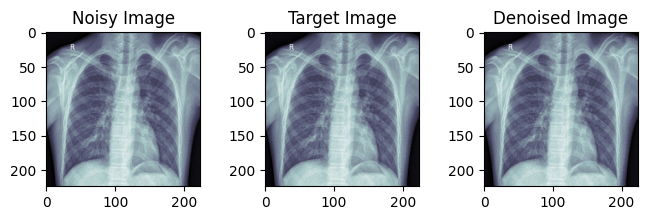

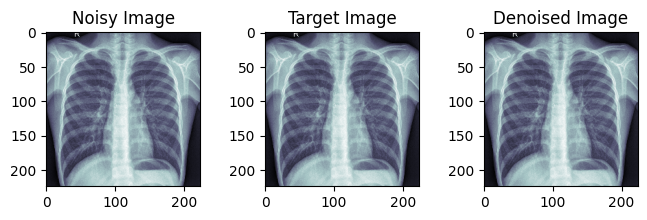

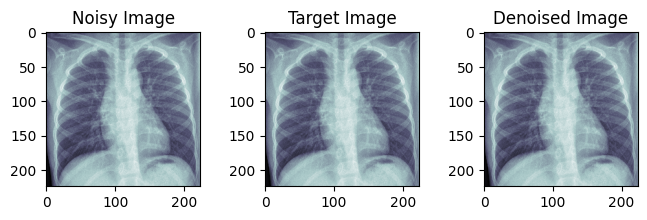

In [7]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import cv2

def load_images(folder, category):
    img_files = glob.glob(os.path.join(folder, category, '*.jpeg'))
    images = []
    for img_path in img_files:
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            images.append(img)
    return np.array(images, dtype=object) if images else np.empty((0,), dtype=object)

# Set the base path for your dataset
base_path = "/content/drive/MyDrive/chest_xray/chest_xray"
train_path = os.path.join(base_path, 'train')
val_path = os.path.join(base_path, 'val')
test_path = os.path.join(base_path, 'test')

# Load images
normal_images = load_images(test_path, category='NORMAL')
pneumonia_images = load_images(test_path, category='PNEUMONIA')

dimension = 224  # Set image dimension

def preprocess_images(images):
    return np.array([cv2.resize(img, (dimension, dimension)) for img in images if img is not None])

# Preprocess images
x_test_noisy = preprocess_images(normal_images[:3])  # Simulated noisy images
x_test = preprocess_images(normal_images[:3])  # Original images (targets)
all_denoised_images = preprocess_images(normal_images[:3])  # Placeholder for denoised images

n = min(3, len(x_test_noisy))  # Ensure we do not exceed available images
for i in range(n):
    fig, axes = plt.subplots(1, 3)
    fig.set_size_inches(8, 2)

    axes[0].set_title('Noisy Image')
    im0 = axes[0].imshow(x_test_noisy[i], cmap='bone')

    axes[1].set_title('Target Image')
    im1 = axes[1].imshow(x_test[i], cmap='bone')

    axes[2].set_title('Denoised Image')
    im2 = axes[2].imshow(all_denoised_images[i], cmap='bone')

    plt.savefig(f'comparison-{i}.png')
    plt.show()

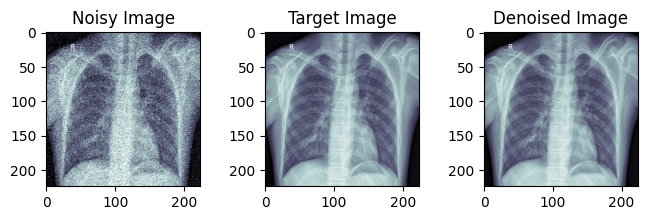

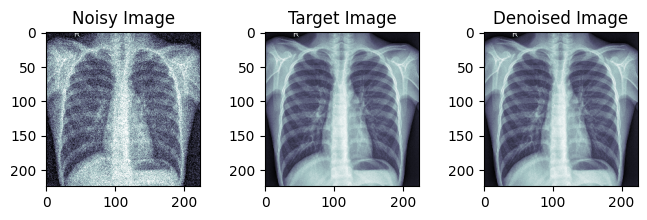

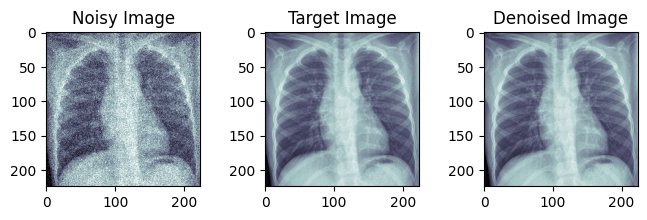

In [9]:
def add_gaussian_noise(images, mean=0, stddev=25):
    noisy_images = []
    for img in images:
        noise = np.random.normal(mean, stddev, img.shape)
        noisy_img = img + noise
        noisy_img = np.clip(noisy_img, 0, 255)  # Ensure pixel values stay valid
        noisy_images.append(noisy_img.astype(np.uint8))
    return np.array(noisy_images)

# Add noise to the test images
x_test_noisy = add_gaussian_noise(x_test)  # Now noisy images are actually noisy
all_denoised_images = x_test  # Placeholder for denoised images (can replace with your denoising algorithm)

# Visualization (same as before)
n = min(3, len(x_test_noisy))  # Ensure we do not exceed available images
for i in range(n):
    fig, axes = plt.subplots(1, 3)
    fig.set_size_inches(8, 2)

    axes[0].set_title('Noisy Image')
    im0 = axes[0].imshow(x_test_noisy[i], cmap='bone')

    axes[1].set_title('Target Image')
    im1 = axes[1].imshow(x_test[i], cmap='bone')

    axes[2].set_title('Denoised Image')
    im2 = axes[2].imshow(all_denoised_images[i], cmap='bone')

    plt.savefig(f'comparison-{i}.png')
    plt.show()


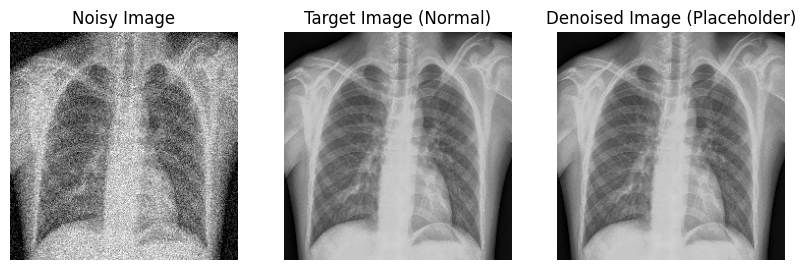

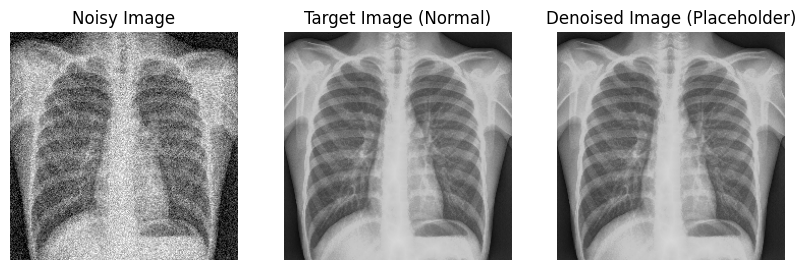

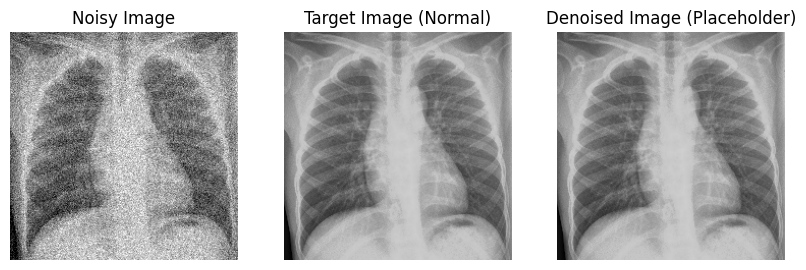

In [10]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import cv2

def load_images(folder, category):
    img_files = glob.glob(os.path.join(folder, category, '*.jpeg'))
    images = []
    for img_path in img_files:
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        if img is not None:
            images.append(img)
    return np.array(images, dtype=object) if images else np.empty((0,), dtype=object)

def preprocess_images(images, dimension):
    return np.array([cv2.resize(img, (dimension, dimension)) for img in images if img is not None])

def add_gaussian_noise(images, mean=0, stddev=25):
    noisy_images = []
    for img in images:
        noise = np.random.normal(mean, stddev, img.shape[:2])  # Add noise to grayscale shape
        noisy_img = img.astype(np.float32)
        noisy_img[:, :, 0] += noise
        noisy_img[:, :, 1] += noise
        noisy_img[:, :, 2] += noise
        noisy_img = np.clip(noisy_img, 0, 255).astype(np.uint8)
        noisy_images.append(noisy_img)
    return np.array(noisy_images)

def remove_text(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, binary_mask = cv2.threshold(gray_image, 200, 255, cv2.THRESH_BINARY_INV)
    text_mask = cv2.bitwise_not(binary_mask)
    inpainted_image = cv2.inpaint(image, text_mask, inpaintRadius=3, flags=cv2.INPAINT_TELEA)
    return inpainted_image

# Set the base path for your dataset
base_path = "/content/drive/MyDrive/chest_xray/chest_xray"
train_path = os.path.join(base_path, 'train')
val_path = os.path.join(base_path, 'val')
test_path = os.path.join(base_path, 'test')

# Load images
normal_images = load_images(test_path, category='NORMAL')
pneumonia_images = load_images(test_path, category='PNEUMONIA')

dimension = 224  # Set image dimension

# Preprocess and clean images
normal_images = preprocess_images([remove_text(img) for img in normal_images], dimension)
pneumonia_images = preprocess_images([remove_text(img) for img in pneumonia_images], dimension)

# Combine normal and pneumonia images with labels
all_images = np.concatenate((normal_images, pneumonia_images), axis=0)
labels = np.array(["Normal"] * len(normal_images) + ["Pneumonia"] * len(pneumonia_images))

# Add noise to all images
noisy_images = add_gaussian_noise(all_images)

def visualize_images(noisy_images, original_images, labels, n=3):
    for i in range(n):
        fig, axes = plt.subplots(1, 3)
        fig.set_size_inches(10, 3)

        axes[0].set_title('Noisy Image')
        axes[0].imshow(cv2.cvtColor(noisy_images[i], cv2.COLOR_BGR2RGB))
        axes[0].axis('off')

        axes[1].set_title(f'Target Image ({labels[i]})')
        axes[1].imshow(cv2.cvtColor(original_images[i], cv2.COLOR_BGR2RGB))
        axes[1].axis('off')

        axes[2].set_title('Denoised Image (Placeholder')
        axes[2].imshow(cv2.cvtColor(original_images[i], cv2.COLOR_BGR2RGB))  # Replace with denoised output
        axes[2].axis('off')

        plt.savefig(f'comparison-{i}.png')
        plt.show()

# Visualize images
visualize_images(noisy_images, all_images, labels)


EXTRA: In Progress--

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


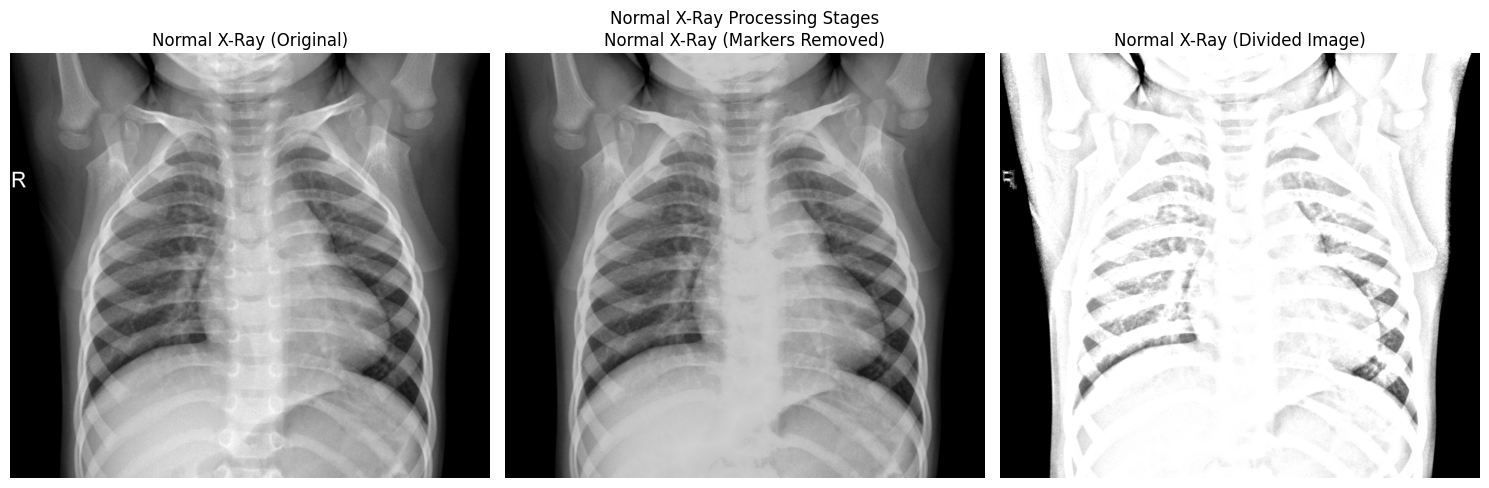

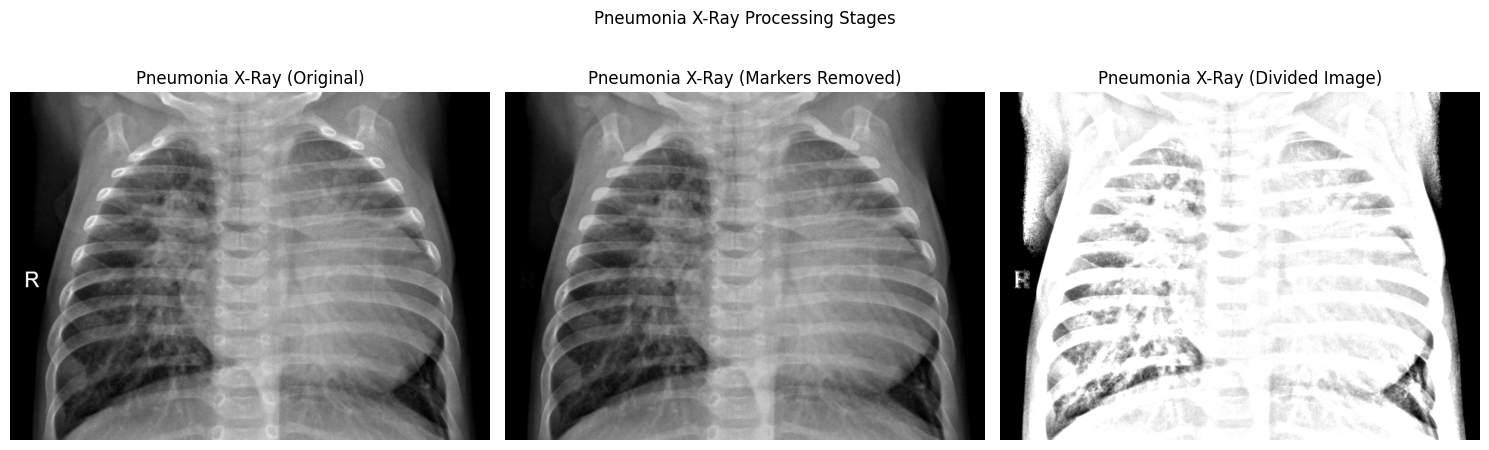

In [ ]:
'''from google.colab import drive
import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
import scipy.ndimage as ndimage

# Mount Google Drive
drive.mount('/content/drive')

class ImageProcessor:
    @staticmethod
    def preprocess_image(image_path):
        """
        Advanced image preprocessing

        Args:
            image_path (str): Path to input image

        Returns:
            tuple: Processed images at different stages
        """
        # Load image
        img = cv2.imread(image_path)

        # Remove text markers
        gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        _, binary_mask = cv2.threshold(gray_image, 200, 255, cv2.THRESH_BINARY_INV)
        text_mask = cv2.bitwise_not(binary_mask)
        img_no_markers = cv2.inpaint(img, text_mask, inpaintRadius=3, flags=cv2.INPAINT_TELEA)

        # Convert to grayscale from marker-free image (img_no_markers)
        gray = cv2.cvtColor(img_no_markers, cv2.COLOR_BGR2GRAY)

        # Blur image
        blur = cv2.GaussianBlur(gray, (0,0), sigmaX=33, sigmaY=33)

        # Divide grayscale (from img_no_markers) by blurred image
        divide = cv2.divide(gray, blur, scale=255)

        return img, img_no_markers, divide

    @staticmethod
    def visualize_processing_stages(image_path, image_type):
        """
        Visualize image processing stages

        Args:
            image_path (str): Path to the input image
            image_type (str): Type of image (Normal or Pneumonia)
        """
        # Process image
        original, no_markers, divided = ImageProcessor.preprocess_image(image_path)

        # Create figure with subplots
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        # Image titles
        titles = [
            f'{image_type} X-Ray (Original)',
            f'{image_type} X-Ray (Markers Removed)',
            f'{image_type} X-Ray (Divided Image)'
        ]

        # Images to display
        images = [original, no_markers, divided]

        # Display images
        for i, (img, title) in enumerate(zip(images, titles)):
            # Convert images for display
            if len(img.shape) == 2:
                img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
            else:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            axes[i].imshow(img, cmap='gray' if len(images[i].shape) == 2 else None)
            axes[i].set_title(title)
            axes[i].axis('off')

        plt.suptitle(f'{image_type} X-Ray Processing Stages')
        plt.tight_layout()
        plt.show()

class SimpleXRayModel:
    def __init__(self, normal_path, pneumonia_path):
        """
        Initialize model with image paths

        Args:
            normal_path (str): Path to the normal X-ray image
            pneumonia_path (str): Path to the pneumonia X-ray image
        """
        self.normal_path = normal_path
        self.pneumonia_path = pneumonia_path
        # Any other initialization required

    def visualize_results(self):
        """
        Visualize the results of the model
        """
        # Visualize preprocessing stages for normal and pneumonia images
        ImageProcessor.visualize_processing_stages(self.normal_path, "Normal")
        ImageProcessor.visualize_processing_stages(self.pneumonia_path, "Pneumonia")

# Paths to your data
normal_path = "/content/drive/MyDrive/chest_xray/chest_xray/train/NORMAL/IM-0526-0001.jpeg"
pneumonia_path = "/content/drive/MyDrive/chest_xray/chest_xray/train/PNEUMONIA/person53_bacteria_252.jpeg"

# Instantiate and run the model
model = SimpleXRayModel(normal_path, pneumonia_path)
model.visualize_results()
